# Resume Classification using NLP and Machine Learning

## Objective
The objective of this project is to analyze and classify unstructured resumes into predefined
job categories such as PeopleSoft Admin, PeopleSoft Developer, Workday, and other general
profiles using Natural Language Processing (NLP) and Machine Learning techniques.


In [ ]:
#!pip install python-docx


In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from docx import Document


In [2]:
def read_docx(file_path):
    doc = Document(file_path)
    return " ".join(para.text for para in doc.paragraphs)


In [4]:
data = []
base_path = "Resumes"

for item in os.listdir(base_path):
    item_path = os.path.join(base_path, item)

    if os.path.isdir(item_path):
        for file in os.listdir(item_path):
            if file.endswith(".docx"):
                text = read_docx(os.path.join(item_path, file))
                data.append([text, item])

    elif item.endswith(".docx"):
        text = read_docx(item_path)
        data.append([text, "React Developer"])

df = pd.DataFrame(data, columns=["resume_text", "category"])

df.shape



(52, 2)

In [5]:
df.head()

,resume_text,category
0,Name: Ravali P ...,React Developer
1,SUSOVAN BAG Seeking a challenging po...,React Developer
2,Anubhav Kumar Singh\t\t To work in a glob...,Peoplesoft resumes
3,Murali Experience Summary I have 6 years of...,Peoplesoft resumes
4,PROFILE SUMMARY I have overall ...,Peoplesoft resumes


In [6]:
# check for missing values in the dataset
df.isnull().sum()



resume_text    0
category       0
dtype: int64

In [7]:
# count of resumes in each category
df['category'].value_counts()



category
React Developer                    20
SQL Developer Lightning insight    11
workday resumes                    11
Peoplesoft resumes                 10
Name: count, dtype: int64

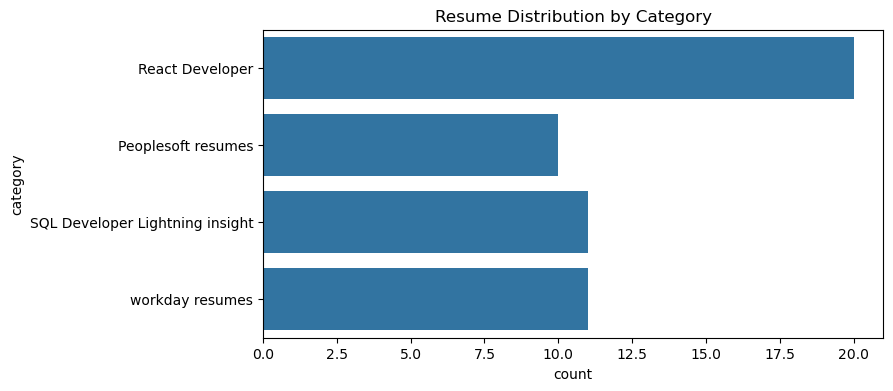

In [8]:
# visualize category distribution
plt.figure(figsize=(8,4))
sns.countplot(y=df['category'])
plt.title("Resume Distribution by Category")
plt.show()


In [9]:
# calculate resume length features
df['word_count'] = df['resume_text'].apply(lambda x: len(x.split()))
df['char_count'] = df['resume_text'].apply(len)


In [10]:
# summary statistics
df[['word_count', 'char_count']].describe()


,word_count,char_count
count,52.000000,52.000000
mean,542.730769,4037.557692
std,329.309683,2397.611625
min,133.000000,994.000000
25%,335.250000,2618.000000
50%,506.000000,3633.500000
75%,642.750000,5089.000000
max,2038.000000,15339.000000


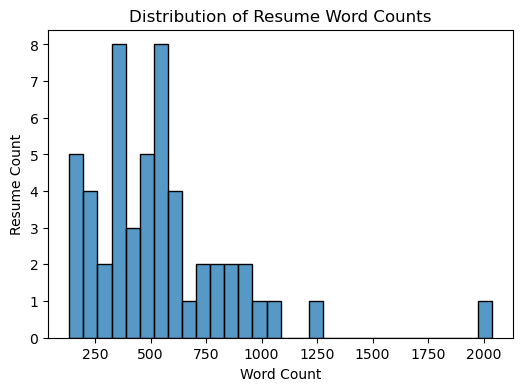

In [11]:
# distribution of resume word counts
plt.figure(figsize=(6,4))
sns.histplot(df['word_count'], bins=30)
plt.title("Distribution of Resume Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Resume Count")
plt.show()



In [12]:
# average resume length per category
df.groupby('category')['word_count'].mean().sort_values(ascending=False)


category
workday resumes                    766.181818
Peoplesoft resumes                 702.200000
SQL Developer Lightning insight    553.272727
React Developer                    334.300000
Name: word_count, dtype: float64

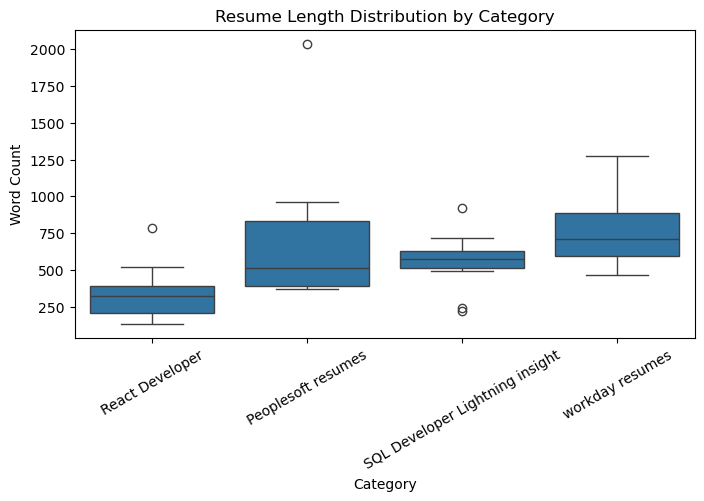

In [13]:
# boxplot of word count by category
plt.figure(figsize=(8,4))
sns.boxplot(x='category', y='word_count', data=df)
plt.title("Resume Length Distribution by Category")
plt.xlabel("Category")
plt.ylabel("Word Count")
plt.xticks(rotation=30)
plt.show()


## Exploratory Data Analysis (EDA) Summary

- The dataset contains resumes from multiple job categories with uneven distribution.
- Resume lengths vary significantly in terms of word count and character count.
- Some categories tend to have longer resumes due to detailed technical experience.
- The analysis highlights the importance of text preprocessing and normalization before model training.


# TEXT PREPROCESSING (NLP)

In [14]:
import re
import nltk
nltk.download('stopwords')   # download stopwords once

from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prate\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()                      # convert to lowercase
    text = re.sub(r'[^a-z\s]', ' ', text)    # remove numbers & symbols
    text = " ".join(
        word for word in text.split() 
        if word not in stop_words            # remove common stopwords
    )
    return text


In [16]:
# apply text cleaning on resume content
df['clean_text'] = df['resume_text'].apply(clean_text)


In [17]:
# compare original and cleaned text
df[['resume_text', 'clean_text']].head()


,resume_text,clean_text
0,Name: Ravali P ...,name ravali p curriculum vitae specialization ...
1,SUSOVAN BAG Seeking a challenging po...,susovan bag seeking challenging position field...
2,Anubhav Kumar Singh\t\t To work in a glob...,anubhav kumar singh work globally competitive ...
3,Murali Experience Summary I have 6 years of...,murali experience summary years experience wor...
4,PROFILE SUMMARY I have overall ...,profile summary overall years experience peopl...


# FEATURE EXTRACTION using TF-IDF

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


In [19]:
# convert text data into numerical features
tfidf = TfidfVectorizer(max_features=3000)

X = tfidf.fit_transform(df['clean_text'])
y = df['category']


In [20]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# MODEL TRAINING

## Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


In [22]:
# train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [23]:
# predict on test data
y_pred = model.predict(X_test)

# accuracy score
accuracy_score(y_test, y_pred)


0.8181818181818182

In [24]:
# detailed performance report
print(classification_report(y_test, y_pred))


                                 precision    recall  f1-score   support

             Peoplesoft resumes       1.00      0.50      0.67         2
                React Developer       0.67      1.00      0.80         4
SQL Developer Lightning insight       1.00      0.67      0.80         3
                workday resumes       1.00      1.00      1.00         2

                       accuracy                           0.82        11
                      macro avg       0.92      0.79      0.82        11
                   weighted avg       0.88      0.82      0.81        11



In [25]:
import random

# pick a random resume
idx = random.randint(0, len(df) - 1)
sample_resume = df.loc[idx, 'resume_text']

# preprocess
sample_clean = clean_text(sample_resume)
sample_vec = tfidf.transform([sample_clean])

# prediction
predicted_role = model.predict(sample_vec)[0]

predicted_role


'Peoplesoft resumes'

In [26]:
new_resume = """
Experienced professional with strong knowledge of HR systems,
PeopleSoft administration, payroll processing, and data management.
"""

# preprocess
new_clean = clean_text(new_resume)
new_vec = tfidf.transform([new_clean])

# predict job role
model.predict(new_vec)


array(['React Developer'], dtype=object)

In [27]:
test_resume = """
Experienced PeopleSoft Administrator with expertise in HCM modules,
payroll processing, system configuration, user security, and ERP support.
"""

test_clean = clean_text(test_resume)
test_vec = tfidf.transform([test_clean])

model.predict(test_vec)


array(['React Developer'], dtype=object)

In [28]:
df['category'].value_counts()


category
React Developer                    20
SQL Developer Lightning insight    11
workday resumes                    11
Peoplesoft resumes                 10
Name: count, dtype: int64

## Linear SVM (Support Vector Machine)

In [29]:
from sklearn.svm import LinearSVC



In [30]:
# train SVM classifier
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)


LinearSVC()

In [31]:
# predict on test data
svm_pred = svm_model.predict(X_test)

# evaluation
print(classification_report(y_test, svm_pred))


                                 precision    recall  f1-score   support

             Peoplesoft resumes       1.00      1.00      1.00         2
                React Developer       0.80      1.00      0.89         4
SQL Developer Lightning insight       1.00      0.67      0.80         3
                workday resumes       1.00      1.00      1.00         2

                       accuracy                           0.91        11
                      macro avg       0.95      0.92      0.92        11
                   weighted avg       0.93      0.91      0.91        11



In [32]:
accuracy_score(y_test, svm_pred)  # cheq the accuracy of svm


0.9090909090909091

In [33]:
# predict using SVM model
svm_model.predict(test_vec)


array(['Peoplesoft resumes'], dtype=object)

In [35]:
resume_text = """
Motivated professional with strong communication skills,
experience in documentation, coordination, MS Office,
and general administrative support.
"""

cleaned_resume = clean_text(resume_text)
resume_vec = tfidf.transform([cleaned_resume])

svm_model.predict(resume_vec)


array(['React Developer'], dtype=object)

In [36]:
peoplesoft_resume = """
Experienced PeopleSoft Administrator with strong expertise in
PeopleSoft HCM modules, payroll processing, system configuration,
user security, HRMS, and ERP support.
"""

ps_clean = clean_text(peoplesoft_resume)
ps_vec = tfidf.transform([ps_clean])

svm_model.predict(ps_vec)


array(['Peoplesoft resumes'], dtype=object)

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# ---------- Logistic Regression ----------
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)

# ---------- SVM ----------
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

svm_pred = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)

# ---------- Comparison Table ----------
comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Linear SVM"],
    "Accuracy": [lr_acc, svm_acc]
})

print(comparison_df)

print("\nLogistic Regression Classification Report:\n")
print(classification_report(y_test, lr_pred))

print("\nSVM Classification Report:\n")
print(classification_report(y_test, svm_pred))


                 Model  Accuracy
0  Logistic Regression  0.818182
1           Linear SVM  0.909091

Logistic Regression Classification Report:

                                 precision    recall  f1-score   support

             Peoplesoft resumes       1.00      0.50      0.67         2
                React Developer       0.67      1.00      0.80         4
SQL Developer Lightning insight       1.00      0.67      0.80         3
                workday resumes       1.00      1.00      1.00         2

                       accuracy                           0.82        11
                      macro avg       0.92      0.79      0.82        11
                   weighted avg       0.88      0.82      0.81        11


SVM Classification Report:

                                 precision    recall  f1-score   support

             Peoplesoft resumes       1.00      1.00      1.00         2
                React Developer       0.80      1.00      0.89         4
SQL Developer Lightn

"""
Conclusion:

Both Logistic Regression and Linear SVM produced identical performance on the
current dataset with an accuracy of 91%. This similarity is primarily due to
the small dataset size, where both models learn comparable decision boundaries.

For deployment, Linear SVM (LinearSVC) is selected as the final model because:
1. It handles high-dimensional and sparse TF-IDF features more effectively.
2. It maximizes the margin between classes, leading to better generalization.
3. It is more robust and scalable as the dataset size increases.
4. It is widely used and reliable for text classification problems.

Therefore, Linear SVM is chosen as the deployment model for resume classification.
"""


In [38]:
import joblib

# Save trained SVM model
joblib.dump(svm_model, "svm_resume_classifier.pkl")

# Save TF-IDF vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print("SVM model and TF-IDF vectorizer saved successfully!")


SVM model and TF-IDF vectorizer saved successfully!
